In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_numerics
import ariel_gp
import ariel_load
import time
import numpy as np
import multiprocess
import importlib
import copy
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm

local


In [128]:
import numpy as np

def fit_als_multi(S, C0, C_list, w_init=None, max_iter=100, tol=1e-8, eps=1e-12, cond_thresh=1e8, ridge_scale=1e-8):
    """
    Minimize || S - diag(w0) * (C0 + sum_k w[k] * C_list[k]) ||_F^2
    where:
      S, C0 : (N, M)
      C_list: list/tuple/array of K matrices each (N, M)
      w0    : (N,) rowwise scales (solved internally)
      w     : (K,) global scalars (solved internally)

    Returns
    -------
    w0 : (N,)
    w  : (K,)
    obj: float, final squared Frobenius residual
    it : int, iterations performed
    """

    # --- shape checks & setup
    S = np.asarray(S)
    C0 = np.asarray(C0)
    Cs = np.asarray([np.asarray(C) for C in C_list])  # (K, N, M)
    K, N, M = Cs.shape[0], S.shape[0], S.shape[1]
    assert C0.shape == (N, M) and np.all([C.shape == (N, M) for C in Cs]), "Shape mismatch"

    # --- helpers
    def update_w0(w):
        # T = C0 + sum_k w[k]*Ck
        T = C0.copy()
        if K:
            T += np.tensordot(w, Cs, axes=(0,0))  # (N, M)
        num = np.sum(S * T, axis=1)              # (N,)
        den = np.sum(T * T, axis=1) + eps        # (N,)
        return num / den

    def update_w(w0):
        # B = S - diag(w0) C0
        B = S - (w0[:, None] * C0)               # (N, M)

        if K == 0:
            return np.zeros(0), 0.0, 0.0  # no global scalars

        # X_k = diag(w0) C_k  -> stack into X: (K, N, M)
        X = w0[:, None] * Cs                  # (K, N, M)

        # Build KxK normal matrix A and rhs b via Frobenius inner products
        # A_ij = <X_i, X_j>,  b_i = <X_i, B>
        A = np.einsum('knm,lnm->kl', X, X)    # (K, K)
        b = np.einsum('knm,nm->k', X, B)      # (K,)

        reg = 0.0
        # Regularize if ill‑conditioned
        try:
            cnd = np.linalg.cond(A)
        except np.linalg.LinAlgError:
            cnd = np.inf
        if not np.isfinite(cnd) or cnd > cond_thresh:
            reg = ridge_scale * (np.trace(A) / max(K, 1) + eps)
            A = A + reg * np.eye(K)

        w = np.linalg.solve(A, b)
        return w, reg, cnd

    # --- initialize
    if w_init is None:
        w = np.zeros(K)
    else:
        w = np.asarray(w_init, dtype=float)
        assert w.shape == (K,)
    w0 = update_w0(w)

    # --- iterate
    prev = np.inf
    it = 0
    for it in range(1, max_iter + 1):
        # Step B: solve for global scalars given w0
        w, reg, cnd = update_w(w0)

        # Step A: closed‑form rowwise w0 given globals
        w0 = update_w0(w)

        # Objective
        T = C0.copy()
        if K:
            T += np.tensordot(w, Cs, axes=(0,0))
        R = S - (w0[:, None] * T)
        cur = float(np.sum(R * R))

        # Convergence (relative decrease in objective)
        if it>1 and abs(prev - cur) <= tol * (prev + 1.0):
            break
        prev = cur

    return w0, w, cur, it

In [133]:
N_wl = 15
N_t = 100
N_r = 10
N_comp = 3

#(comp,t,r,wl)

c0 = np.random.default_rng(seed=0).normal(size=(N_r,N_wl))
c = np.random.default_rng(seed=1).normal(size=(N_comp,N_r,N_wl))
w0 = np.random.default_rng(seed=2).normal(size=(N_t, N_wl))+1
w = np.random.default_rng(seed=3).normal(size=(N_comp, N_t))

signal = w0[:,None,:] * c0[None,:,:]
for ii in range(N_comp):
    signal += w0[:,None,:]*w[ii,...][:,None,None]*c[ii,...][None,:,:]
signal.shape

(100, 10, 15)

In [134]:
c0_guess = np.random.default_rng(seed=5).normal(size=(N_r,N_wl))
c_guess = 0*c
w0_guess = np.random.default_rng(seed=8).normal(size=(N_t, N_wl))
w_guess = np.random.default_rng(seed=9).normal(size=(N_comp, N_t))

c0_guess = copy.deepcopy(c0);c_guess = copy.deepcopy(c);#w0_guess=copy.deepcopy(w0); w_guess=copy.deepcopy(w);

In [135]:
import scipy
for i_iter in tqdm(range(1000)):
    # c update
    for i_r in range(N_r):
        for i_wl in range(N_wl):
            w_matrix = np.concatenate([w0_guess[:,i_wl][None,:], w0_guess[:,i_wl]*w_guess])
            rhs = signal[:,i_r,i_wl]
            coeffs = np.linalg.lstsq(w_matrix.T, rhs, rcond=None)[0]
            c0_guess[i_r,i_wl] = coeffs[0]
            c_guess[:,i_r,i_wl] = coeffs[1:]
    
    c0_guess = c0_guess/kgs.rms(c0_guess)
    for i_comp in range(N_comp):
        c_guess[i_comp,...] = c_guess[i_comp,...]/kgs.rms(c_guess[i_comp,...])
        
    c0_guess = copy.deepcopy(c0)
    c_guess = copy.deepcopy(c)
    #c_guess[:,:,5]*=20
    
            
    # w0 update
    for i_t in range(N_t):
        for i_wl in range(N_wl):
            pass
            y = signal[i_t,:,i_wl]
            x = copy.deepcopy(c0_guess[:,i_wl])
            for i_c in range(N_comp):
                 x += w_guess[i_c,i_t]*c_guess[i_c,:,i_wl]
            w0_guess[i_t,i_wl] = np.sum(x*y)/np.sum(x*x)
           # print(w0_guess[i_t,i_wl]- w0[i_t,i_wl])
    
    #w0_guess = w0
        
    # w update
    design_matrix = c_guess.reshape(N_comp,-1)
    for i_t in range(N_t):
        rhs = signal[i_t,...]/w0_guess[i_t,None,:] - c0_guess[None,:,:]
        rhs = rhs.reshape(-1)
        coeffs = np.linalg.lstsq(design_matrix.T, rhs, rcond=None)[0]
        w_guess[:,i_t] = coeffs
        
    
        
#     def f(x):
#         w0_guess = x[:N_wl]
#         w_guess = x[N_wl:]
#         signal_guess = w0_guess[None,:] * c0_guess[:,:]
#         for ii in range(N_comp):
#             signal_guess += w0_guess[None,:]*w_guess[ii]*c_guess[ii,...][:,:]
#         return kgs.rms(signal[i_t,...] - signal_guess)
    
#     for i_t in range(N_t):
#         #print(i_t)
#         w0_guess[i_t,:], w_guess[:,i_t],a,b = fit_als_multi(copy.deepcopy(signal[i_t,...].T), copy.deepcopy(c0_guess).T, copy.deepcopy([c_guess[0,...].T, c_guess[1,...].T, c_guess[2,...].T]))
#         #w0_guess[i_t,:] = w0[i_t,:]
#         #w_guess[:,i_t] = w[:,i_t]
    
#         # x0 = np.concatenate((w0_guess[i_t,...],w_guess[:,i_t]))
#         # res=scipy.optimize.minimize(f,x0,method='COBYLA')
#         # #print(res)
#         # print(f(res.x))
#         # #res=scipy.optimize.minimize(f,res.x)
#         # w0_guess[i_t,:] = res.x[:N_wl]
#         # w_guess[:,i_t] = res.x[N_wl:]
        
    #w_guess = w
    #w0_guess = w0;
    #w_guess = w;
        
    
    signal_guess = w0_guess[:,None,:] * c0_guess[None,:,:]
    for ii in range(N_comp):
        signal_guess += w0_guess[:,None,:]*w_guess[ii,...][:,None,None]*c_guess[ii,...][None,:,:]
    if i_iter%10==0:
        print(kgs.rms(w0_guess-w0), kgs.rms(w_guess-w), kgs.rms(c0_guess-c0), kgs.rms(c_guess-c), kgs.rms(signal-signal_guess))
print(kgs.rms(w0_guess-w0), kgs.rms(w_guess-w), kgs.rms(c0_guess-c0), kgs.rms(c_guess-c), kgs.rms(signal-signal_guess))

  2%|█▏                                                                               | 15/1000 [00:00<00:13, 70.78it/s]

1.2214107816126993 9.948708556331491 0.0 0.0 8.489514864236934
0.9999379208618543 11165.32514378032 0.0 0.0 0.9650950107363819


  3%|██▌                                                                              | 31/1000 [00:00<00:13, 69.32it/s]

0.9360884064217752 250305.0344160175 0.0 0.0 0.8467816621074009
0.9101882637391281 48255712.62662489 0.0 0.0 0.8376929063374905


  5%|████▎                                                                            | 53/1000 [00:00<00:13, 67.78it/s]

0.8881805027096028 1022846609.1862992 0.0 0.0 0.8917658789084721
0.870952120791285 2564490781.311418 0.0 0.0 0.7907553697768543


  8%|██████                                                                           | 75/1000 [00:01<00:13, 68.26it/s]

0.8574852295309412 14371954155.095808 0.0 0.0 0.8005638170019383
0.8507426648456884 30947255851234.023 0.0 0.0 1.7871105253259285


  9%|███████▎                                                                         | 90/1000 [00:01<00:13, 69.15it/s]

0.8413792396257905 53167733172471.98 0.0 0.0 0.7747822861685761
0.8331740089933672 110485055095433.28 0.0 0.0 0.7558742137245801


 11%|████████▉                                                                       | 112/1000 [00:01<00:13, 68.22it/s]

0.8262357699072238 2974318121402880.0 0.0 0.0 0.7427065146625503
0.8246592139036366 2.776727796199511e+16 0.0 0.0 0.744433374807934


 13%|██████████▏                                                                     | 127/1000 [00:01<00:13, 66.78it/s]

0.8233278148384591 4.65327491455949e+18 0.0 0.0 0.7580010947675774
0.8221630409277377 1.2527217599494576e+19 0.0 0.0 0.7578172013528617


 15%|███████████▉                                                                    | 149/1000 [00:02<00:12, 68.44it/s]

0.8211328228270178 3.6965456416342377e+22 0.0 0.0 0.7554469428686741
0.8202125134882882 2.551963547483335e+23 0.0 0.0 1.1623344686477233


 17%|█████████████▋                                                                  | 171/1000 [00:02<00:12, 65.33it/s]

0.8193827354948402 8.366853961734291e+23 0.0 0.0 0.7474734037563308
0.8186279136012888 2.2387870278656537e+26 0.0 0.0 0.7394019802416186


 19%|███████████████▍                                                                | 193/1000 [00:02<00:12, 65.40it/s]

0.817935234693669 1.572327173923384e+28 0.0 0.0 0.7422239868740329
0.8172938805023638 1.652461970968017e+30 0.0 0.0 0.7409620370393684


 22%|█████████████████▏                                                              | 215/1000 [00:03<00:11, 67.33it/s]

0.8166944320298227 4.37366529481161e+31 0.0 0.0 0.7581046424776848
0.8161283741768683 1.6590690784640697e+35 0.0 0.0 0.762936041093242


 23%|██████████████████▍                                                             | 230/1000 [00:03<00:11, 66.81it/s]

0.8155876434120365 9.477457779105044e+37 0.0 0.0 0.7425481680143211
0.815064164257246 8.05255502797894e+44 0.0 0.0 0.7474351815184965


 25%|████████████████████                                                            | 251/1000 [00:03<00:11, 65.27it/s]

0.8145493122136074 2.092514497327944e+47 0.0 0.0 0.8404369063230129
0.8140332189811696 1.1082680233149219e+48 0.0 0.0 0.7324854475172159


 27%|█████████████████████▊                                                          | 272/1000 [00:04<00:11, 65.85it/s]

0.8135037952240389 1.127886979818519e+48 0.0 0.0 0.7447146517833452
0.8129452814308104 5.0894830798735466e+48 0.0 0.0 0.7859680192301207


 29%|███████████████████████▍                                                        | 293/1000 [00:04<00:11, 63.34it/s]

0.8123360592295593 1.6610001400982454e+52 0.0 0.0 0.7680619564400644
0.8116454652981695 3.6370445292000384e+53 0.0 0.0 1.0724144845226569


 32%|█████████████████████████▏                                                      | 315/1000 [00:04<00:10, 66.20it/s]

0.8108299570432115 2.1867263718518192e+55 0.0 0.0 0.7357605881709647
0.8098322990562231 6.5628279832563485e+56 0.0 0.0 0.732610028782071


 33%|██████████████████████████▍                                                     | 330/1000 [00:04<00:09, 68.36it/s]

0.8086004133144681 2.534922028466996e+57 0.0 0.0 0.7294365381840815
0.8071729678617992 5.882092900136161e+61 0.0 0.0 0.7545184603597279


 35%|████████████████████████████▏                                                   | 352/1000 [00:05<00:09, 67.01it/s]

0.8058390969699465 9.860417794121783e+64 0.0 0.0 0.7672260422908233
0.8049995433158182 2.0323459045390657e+66 0.0 0.0 0.7825397631829712


 37%|█████████████████████████████▉                                                  | 374/1000 [00:05<00:09, 68.30it/s]

0.804618266949345 1.5384448493236277e+68 0.0 0.0 0.754834902488081
0.8044086937058541 2.0526359130524105e+68 0.0 0.0 0.7314442257528994


 39%|███████████████████████████████                                                 | 389/1000 [00:05<00:08, 68.45it/s]

0.804238863826182 3.5930365664443815e+70 0.0 0.0 0.724298336430349
0.8040811475841719 1.1422261978634986e+74 0.0 0.0 0.7232898946426689


 41%|████████████████████████████████▉                                               | 411/1000 [00:06<00:08, 67.49it/s]

0.8039311899242652 1.1780836223590057e+77 0.0 0.0 0.7384289669727834
0.8037880365800125 4.7707523093674265e+81 0.0 0.0 0.9986853249137453


 43%|██████████████████████████████████▋                                             | 434/1000 [00:06<00:08, 69.77it/s]

0.8036511858621173 1.295197920252479e+85 0.0 0.0 0.7323394520318922
0.8035202221370644 1.8714226365903306e+86 0.0 0.0 0.7244531591606169


 45%|████████████████████████████████████                                            | 450/1000 [00:06<00:07, 70.61it/s]

0.8033947700037184 1.815378430865831e+89 0.0 0.0 0.7327262884543722
0.8032744859454818 2.0291021715534409e+89 0.0 0.0 0.7226424463804987


 47%|█████████████████████████████████████▊                                          | 473/1000 [00:07<00:07, 67.76it/s]

0.8031590545969245 2.7358507032657273e+90 0.0 0.0 0.726766202504044
0.8030481858636492 1.3798127165585728e+92 0.0 0.0 0.7241765570131312


 49%|███████████████████████████████████████                                         | 488/1000 [00:07<00:07, 67.27it/s]

0.8029416124283112 4.39123985333094e+93 0.0 0.0 0.9686199080602923
0.802839087551309 6.539724982842188e+94 0.0 0.0 0.7262832341900187


 51%|████████████████████████████████████████▊                                       | 510/1000 [00:07<00:07, 68.37it/s]

0.8027403831225257 2.0009220896662237e+97 0.0 0.0 0.72834212670666
0.8026452879308279 2.1921922180345485e+98 0.0 0.0 0.8888274058313395


 53%|██████████████████████████████████████████▌                                     | 532/1000 [00:07<00:06, 67.11it/s]

0.8025536061233377 8.484065303103027e+101 0.0 0.0 0.8694743473936188
0.802465155830585 1.933045185159401e+103 0.0 0.0 0.722986150654931


 55%|████████████████████████████████████████████▎                                   | 554/1000 [00:08<00:06, 69.79it/s]

0.8023797679370297 5.2298432487309483e+104 0.0 0.0 0.7207678780541623
0.802297284979301 9.743723537071545e+108 0.0 0.0 0.7242360998043248


 57%|█████████████████████████████████████████████▌                                  | 569/1000 [00:08<00:06, 67.24it/s]

0.8022175601569119 1.1154656559528328e+111 0.0 0.0 0.7415654472756575
0.8021404564422584 2.0719425150504197e+115 0.0 0.0 2.163316516808878


 59%|███████████████████████████████████████████████▎                                | 591/1000 [00:08<00:05, 68.84it/s]

0.802065845778447 4.8719913584282124e+116 0.0 0.0 0.722964228664398
0.8019936083549936 2.3384922729886206e+121 0.0 0.0 0.7334103291601296


 61%|████████████████████████████████████████████████▉                               | 612/1000 [00:09<00:05, 66.26it/s]

0.8019236319526984 3.9658710447662735e+122 0.0 0.0 0.7227535563463564
0.8018558113501023 6.087042474574813e+124 0.0 0.0 0.7280766819504787


 64%|██████████████████████████████████████████████████▊                             | 635/1000 [00:09<00:05, 67.68it/s]

0.801790047784865 5.593439003763752e+127 0.0 0.0 0.8269361965511924
0.8017262484642201 6.036738346570625e+129 0.0 0.0 0.741254073275069


 65%|████████████████████████████████████████████████████                            | 650/1000 [00:09<00:05, 67.87it/s]

0.8016643261193634 3.791301161328993e+131 0.0 0.0 0.7201133953660346
0.8016041985992337 3.748564411326426e+134 0.0 0.0 0.7929856968117998


 67%|█████████████████████████████████████████████████████▊                          | 672/1000 [00:10<00:04, 67.99it/s]

0.8015457884996817 2.8107115815472766e+138 0.0 0.0 0.7759654927650226
0.8014890228244765 3.501962833005035e+141 0.0 0.0 0.8047887017019778


 69%|███████████████████████████████████████████████████████▌                        | 694/1000 [00:10<00:04, 66.33it/s]

0.8014338326750026 5.06717878133661e+142 0.0 0.0 0.7322976423973748
0.8013801529658505 3.0035795332052237e+145 0.0 0.0 0.9068667438671935


 71%|████████████████████████████████████████████████████████▋                       | 709/1000 [00:10<00:04, 68.49it/s]

0.8013279221638145 2.843020639836101e+148 0.0 0.0 0.9359745695034345
0.8012770820480746 1.3854087339522517e+150 0.0 0.0 0.736526906535736


 72%|█████████████████████████████████████████████████████████▎                      | 716/1000 [00:10<00:04, 66.88it/s]

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

In [6]:
fit_als_multi(signal[i_t,...], c0_guess, [c_guess[0,...], c_guess[1,...], c_guess[2,...]])

(array([0.88603234, 1.5011748 , 2.05460843, 1.40856635, 1.46526694,
        1.86372778, 1.86521856, 1.94581101, 1.79904742, 1.05689726]),
 array([ 1.52583436, -0.66756506,  0.91188603]),
 992.7032986375576,
 1)

In [73]:
a,b

(3.406153380227487e-09, 16)

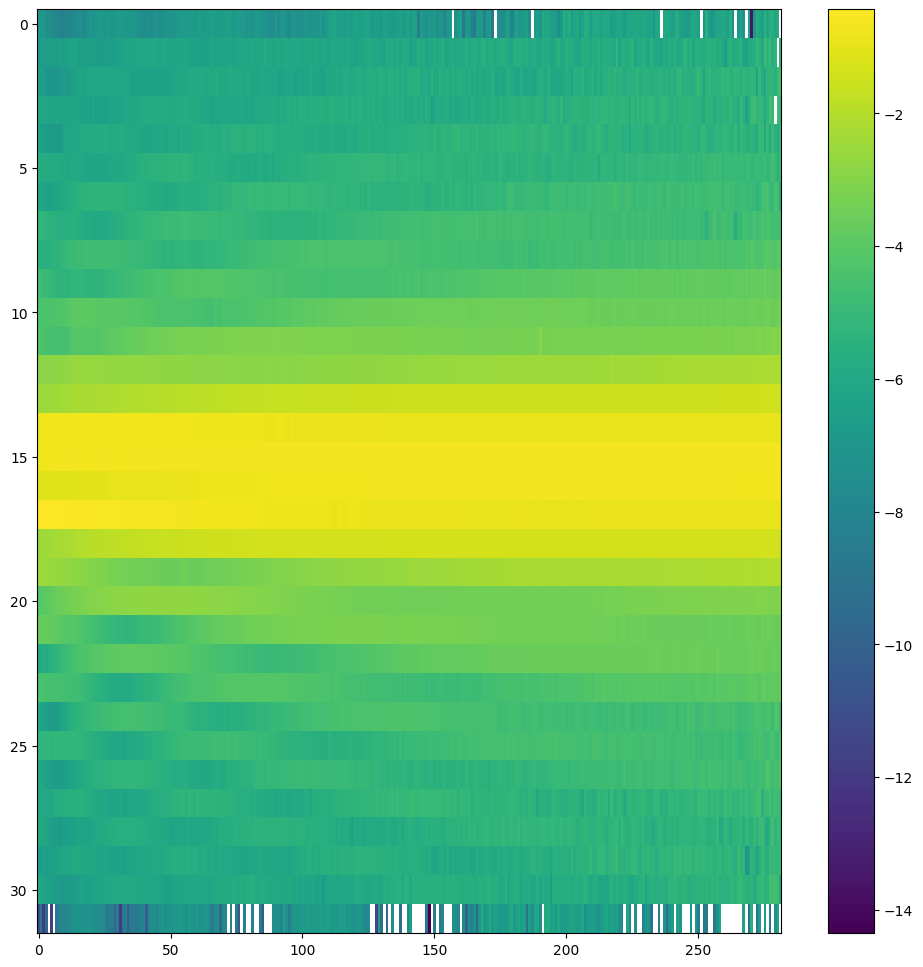

In [119]:
if False:
    def correct_AIRS_jitter(data):

        data_inpaint = copy.deepcopy(data)

        # Rescale
        ariel_load.inpaint_vectorized(data_inpaint)
        if kgs.debugging_mode>=1:
            assert not cp.any(cp.isnan(data_inpaint))
        x=cp.mean(data,(0,1))
        data[...] = data/x*base_scaling
        orig_shape = data.shape   
        data = data.reshape(-1,orig_shape[1]*orig_shape[2])

        design_matrix = cp.array(C_combined)[:2,:]
        coeffs = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data.T, design_matrix.T, return_A_pinv_w=False)[0]
        data -= (design_matrix.T@coeffs).T

        # Unscale
        data = data.reshape(orig_shape)
        data[...] = data*x/base_scaling

        return data


    R_row = np.memmap(kgs.temp_dir + 'AIRS_row.memmap',  dtype=np.float32, mode='r', shape=(1125*len(train_data), 32*282), order='C')#[:50000,...]

    data = []
    for ii in tqdm(range(len(train_data))):
        this_data = cp.array(np.mean(R_row[1125*ii:1125*(ii+1),...],0), dtype=cp.float64).reshape(1,32,282)
        this_data = correct_AIRS_jitter(this_data)
        data.append(this_data)
    data = cp.concatenate(data)
    #data = data-cp.mean(data,0)
    data.shape
    C0_combined = cp.zeros( (32,282) )
    for i_wavelength in tqdm(range(282)):
        this_data = data[:,:,i_wavelength]    
        C0_combined[:,i_wavelength]=ariel_numerics.nan_pca(this_data,1)[1][0,:]
        C0_combined[:,i_wavelength] = C0_combined[:,i_wavelength]*np.sign(C0_combined[15,i_wavelength])
        
    kgs.dill_save(kgs.calibration_dir + 'AIRS_C0.pickle', (C0_combined))
    
C0_combined = kgs.dill_load(kgs.calibration_dir + 'AIRS_C0.pickle')
plt.figure(figsize=(12,12))
plt.imshow(cp.log(C0_combined).get(), aspect='auto', interpolation='none')
plt.colorbar()

In [139]:
def get_coeffs(data):
    
    data_inpaint = copy.deepcopy(data)

    # Rescale
    ariel_load.inpaint_vectorized(data_inpaint)
    if kgs.debugging_mode>=1:
        assert not cp.any(cp.isnan(data_inpaint))
    x=cp.mean(data_inpaint,1)
    data[...] = data/x[:,None,:]*base_scaling
    orig_shape = data.shape   
    data = data.reshape(-1,orig_shape[1]*orig_shape[2])
    
    noise_est = ariel_numerics.estimate_noise_cp(data)
    
#     plt.figure()
#     plt.imshow(cp.mean(data,0).reshape(32,282).get(), interpolation='none', aspect='auto')
    
#     plt.figure()
#     plt.imshow(ariel_numerics.estimate_noise_cov_cp(data.reshape(1125,32,282)[:,:,0]).get())
#     plt.colorbar()
    for ii in range(3):
        

#         plt.figure()
#         plt.plot(noise_est.get())

        design_matrix = cp.zeros((2+282,32*282))
        design_matrix[:2,:] = cp.array(C_combined[:2,:])
        for i_wavelength in range(282):
            #design_matrix[i_wavelength+2,32*i_wavelength:32*(i_wavelength+1)] = C0_combined[:,i_wavelength]
            design_matrix[i_wavelength+2,i_wavelength::282] = C0_combined[:,i_wavelength]
            
#         plt.figure()
#         plt.plot(cp.log(cp.sum(design_matrix,0)).get())
        
#         plt.figure()
#         plt.plot(cp.log(cp.sum(design_matrix,1)).get())
        
        assert not cp.any(cp.isnan(design_matrix))
 
        #noise_est = cp.sqrt(cp.abs(C0_combined)).flatten()
        for ii in range(8):
            noise_est[282*ii:282*(ii+1)]*=10000
            #noise_est[31-ii::32]*=100
        for ii in range(24,32):
            noise_est[282*ii:282*(ii+1)]*=10000
        res = ariel_numerics.lstsq_nanrows_normal_eq_with_pinv_sigma(data.T, design_matrix.T, return_A_pinv_w=True, sigma=noise_est)  
        coeffs = res[0]
        
        A_pinv_w = res[1]
        A_pinv_w_full = cp.zeros((284,9024))
        A_pinv_w_full[:,~cp.isnan(data[0,:])] = A_pinv_w
        # plt.figure()
        # plt.plot(A_pinv_w_full[2,::282].get())
        #plt.plot(design_matrix[2,::282].get())
        #plt.plot((noise_est[::282]/kgs.rms(noise_est[::282])).get())
        
        xx = noise_est[::282]/cp.sqrt(design_matrix[2,::282])
        #plt.semilogy((xx/kgs.rms(xx)).get())
        #print(A_pinv_w.shape, data.shape, design_matrix.shape)
        # sens = cp.zeros((32,282))
        # for i_wavelength in range(282):
        #     sens[:,i_wavelength] = A_pinv_w[:]
        #plt.figure()
        #plt.imshow(cp.mean(residual,0).reshape(32,282).get(), aspect='auto', interpolation='none')
        #plt.colorbar()
    
        assert not cp.any(cp.isnan(coeffs))

        residual = (data.T - design_matrix.T@coeffs).T
        
        # plt.figure()
        # plt.imshow(cp.mean(residual,0).reshape(32,282).get(), aspect='auto', interpolation='none')
        # plt.colorbar()
        
        noise_est = ariel_numerics.estimate_noise_cp(residual)
        
        # plt.figure()
        # plt.imshow(ariel_numerics.estimate_noise_cov_cp(residual.reshape(1125,32,282)[:,:,0]).get())
        # plt.colorbar()
        
#         plt.figure()
#         plt.plot(cp.std(coeffs[2:,:],1).get())
        
       # plt.figure()
       # plt.plot(cp.mean(coeffs[2:,:],1).get())
        
        coeffs_wl = []
        for i_wavelength in range(282):
            coeffs_wl.append( coeffs[[2+i_wavelength,0,1],:] )
            coeffs_wl[-1] = coeffs_wl[-1] / base_scaling[i_wavelength] * x[:,i_wavelength]
            
        coeffs_wl = [c.T.get() for c in coeffs_wl]
 
    return coeffs_wl
 
R_row = np.memmap(kgs.temp_dir + 'AIRS_row.memmap',  dtype=np.float32, mode='r', shape=(1125*len(train_data), 32*282), order='C')#[:50000,...]
all_coeffs =[]
for ii in tqdm(range(len(train_data[:100]))):
    data = cp.array(R_row[1125*ii:1125*(ii+1),...], dtype=cp.float64).reshape(1125,32,282)
    all_coeffs.append(get_coeffs(data))
#all_coeffs = cp.concatenate([c.T for c in all_coeffs])
#all_coeffs.shape

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]


In [140]:
32*282

9024

In [141]:
kgs.debugging_mode = 1
model = ariel_gp.PredictionModel()
model.run_in_parallel = False
model.model_options.n_iter=0
model.model_options.use_training_labels = True
model.train(train_data)

In [142]:
loaded_res = kgs.dill_load(kgs.temp_dir + '/prep.pickle')

In [143]:
model.infer(train_data[0:1]);

In [144]:
transits = []
for d,r in tqdm(zip(train_data,loaded_res)):
    mm= copy.deepcopy(model.results['model_mean'])
    mm= copy.deepcopy(model.results['model_mean'])
    mm.m['signal'].m['main'].m['transit'].transit_params[0][0] = d.transit_params
    mm.m['signal'].m['main'].m['transit'].transit_params[0][0].u = [0,0]
    mm.m['signal'].m['main'].m['transit'].transit_params[0][1] = d.transit_params
    mm.m['signal'].m['main'].m['transit'].transit_params[0][1].u = [0,0]
    mm.set_parameters(r[0])
    mm.m['signal'].m['main'].m['transit'].depth_model.offset = -d.diagnostics['training_spectrum']    
    obs_transit = copy.deepcopy(model.results['obs'])
    
    stellar_labels = mm.m['signal'].m['main'].m['spectrum'].get_prediction(obs_transit)
    transit_labels = mm.m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
    obs_transit.labels = stellar_labels*transit_labels
    #obs_transit.labels = model.results['model_mean'].m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
    #obs_transit.labels = mm.m['signal'].m['main'].get_prediction(obs_transit)
    #obs_transit.labels = mm.m['signal'].get_prediction(obs_transit)
    #print(mm.m['signal'].m['main'].m['transit'].get_parameters())
    #d.diagnostics['transit'] = obs_transit
    transits.append(obs_transit.export_matrix(True))
del loaded_res
del mm
del model
transits = np.array(np.concatenate(transits))

100it [00:12,  7.71it/s]


In [145]:
rr=[]
for i_wavelength in tqdm(range(282)):
    this_coeffs = np.concatenate([c[i_wavelength] for c in all_coeffs])
    this_transit = transits[:,i_wavelength]
    rr.append(np.linalg.lstsq(this_coeffs, this_transit, rcond=None)[0])

100%|████████████████████████████████████████████████████████████████████████████████| 282/282 [00:00<00:00, 472.49it/s]


In [146]:
coeffs0.shape, rr[jj].shape

((1125, 3), (3,))

0.0014523781675363683 0.0015940319527894273
81653.4777198908 111604.70134325796


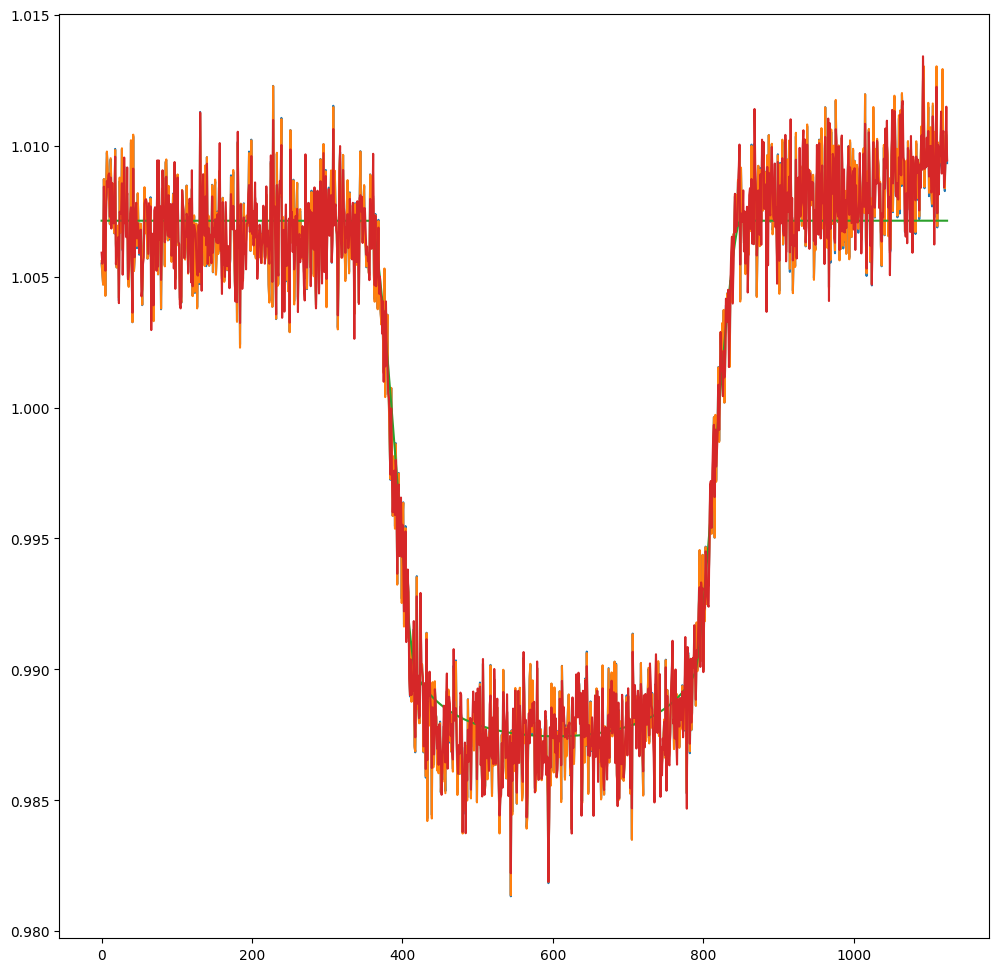

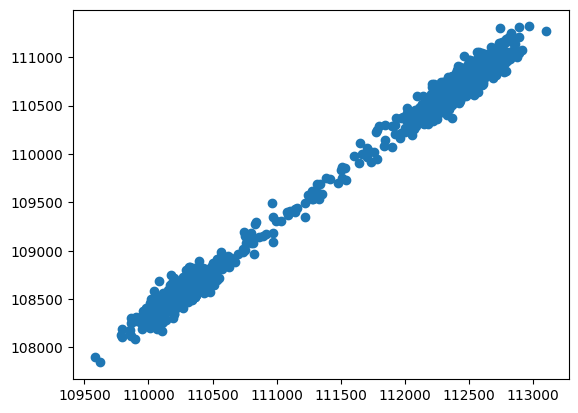

In [147]:
plt.figure(figsize=(12,12))
jj=0
coeffs0 = np.concatenate([c[jj] for c in all_coeffs])
pred = np.sum(coeffs0*rr[jj],1)
ii=0
slic = slice(ii*1125,(ii+1)*1125)
#plt.plot(coeffs0[slic,0]/kgs.rms(coeffs0[slic,0]))
#plt.plot(coeffs0[slic,2]/kgs.rms(coeffs0[slic,2]))
plt.plot(pred[slic]/kgs.rms(pred[slic]))
plt.plot(coeffs0[slic,0]/kgs.rms(coeffs0[slic,0]))
plt.plot(transits[slic,jj]/kgs.rms(transits[slic,jj]))

d = copy.deepcopy(train_data[ii])
loaders = ariel_load.default_loaders()
#loaders[0].cache_steps = []
for ii in range(2):
    loaders[ii].apply_pixel_corrections.mask_hot=False
loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = False
loaders[1].apply_full_sensor_corrections.remove_background_remove_used_rows = False
d.load_to_step(5, loaders)

xx = d.transits[0].data[1].data[:,jj].get()
plt.plot(xx/kgs.rms(xx))

plt.figure()
plt.scatter(xx, pred[slic])
#plt.xlim([1125,2*1125])
#plt.ylim([0.73,0.79])
print(ariel_numerics.estimate_noise_cp(cp.array(xx/kgs.rms(xx))), ariel_numerics.estimate_noise_cp(cp.array(pred[slic]/kgs.rms(pred[slic]))))
print(kgs.rms(pred), kgs.rms(xx))